# Lecture8 最適化を使ってSVMを解く
<div dir='rtl'>
2022.4岩政
</div>

ここでは、sklearn.svmを使わずに、定式化を愚直に、最適化計算で決定境界とマージンを求める例を示す。

参考：[線形SVM(Support Vector Machine)を敢えてscipy.optimizeで実装してみた](https://qiita.com/rtok/items/f50e3ed2483a5ac55e31)

SMVにおける双対問題の定式化では、以下の$f(\alpha)$を最小化する$\alpha$を求める問題に帰着できた。（スライドでは、符号が逆で、最大化問題(argmax)であるとしたが、同じこと)

$$
\argmin_{\alpha} f(\alpha)
$$

\begin{align}
f(\alpha) &=  \frac{1}{2}\sum_{i,j=1}^l\alpha_i\alpha_jy_iy_jx_i^{\mathrm{T}}x_j - \sum_{i=1}^l\alpha_i \\
g_i(\alpha_i) &= \alpha_i \ge 0, \quad i = 1, \dots, l \\
h(\alpha) &= \sum_{i=1}^l{\alpha_iy_i} = 0
\end{align}


scipyパッケージのoptimizeライブラリには、この最適化問題（最小化）をもとめる関数minimizeがある

```
from scipy.optimize import minimize

cons = [{"type": "ineq", "fun": g}]
res = minimize(fun, x0, method="SLSQP", constraints=cons)

```

- funは最適化する関数
- x0は初期値、0でよい
- methodは最適化の手法で、"SLSQP"(=Sequential Least SQuares Programming(逐次二次計画法))をここではつかう
- constraintsは制約で、上記例だと、等式制約$g(x)=0$を指定していることになります。 

最初に、データを作成する

In [31]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

ONE_DATA = 30
x = np.vstack((np.random.normal(loc=-2, scale=1.0, size=(ONE_DATA, 2)),\
        np.random.normal(loc=2, scale=1.0, size=(ONE_DATA, 2))))
y = np.hstack((np.repeat(-1, ONE_DATA), np.repeat(1, ONE_DATA)))

生成されたデータはこちら

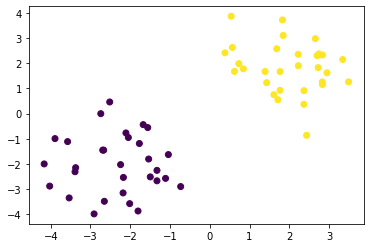

In [32]:
plt.scatter(x[:,0],x[:,1],c=y)

目的関数、不等式制約、等式制約を定義します。ここでは、pythonのクロージャーというやり方で関数を定義しています（関数を返す関数といういみ）

In [33]:
# 目的関数
# x, yはデータで、データを指定して関数を実行すると引数が$\alpha$の関数が返ってくるのでそれを`minimize`に使わせる。
def get_obj(x, y):
    def obj(alpha):
        second = np.array([alpha[i]*alpha[j]*y[i]*y[j]*np.dot(x[i], x[j]) \
                for i in range(len(alpha)) for j in range(len(alpha))])
        return  - np.sum(alpha) + .5 * np.sum(second)
    return obj

# 不等式制約（制約の数だけ作れるようにしていることに注意）
def get_g(i):
    def g(alpha):
        return alpha[i]
    return g

# 等式制約
def get_h(y):
    def h(alpha):
        return np.sum([alpha[i]*y[i] for i in range(len(alpha))])
    return h

目的関数や制約を、constraintsに積みます

In [34]:
cons = [
    {'type': 'eq', 'fun': get_h(y)}  # 等式制約
]
for i in range(len(x)):
    cons.append({'type': 'ineq', 'fun': get_g(i)})  # 不等式制約

最適化(minimize)を実行します。



In [35]:
res = minimize(get_obj(x, y), np.zeros(len(x)), constraints=cons, method="SLSQP")
res

     fun: -0.2118760584383288
     jac: array([ 1.42196708,  2.05071852,  1.43612298,  1.59944294,  0.49742597,
        0.05188346,  0.71497243,  0.40666428,  0.97439515,  1.72406037,
        1.66853388,  2.22240538,  2.14150348,  0.55766934,  0.74513804,
        0.4436715 ,  0.16830567,  0.56425565,  0.96207988,  1.11094765,
        1.96200003,  1.34864786,  0.03573991,  0.95521435,  1.31362914,
        0.15626596,  0.38743508,  0.48620488,  1.42213699,  0.45091385,
        1.38014479,  1.58527352,  1.1364772 ,  0.39368512,  1.07020434,
        0.37067184,  0.13975737,  0.97566527,  0.29795209,  0.11862013,
        1.38323165,  0.56982012,  1.35271766,  0.60008703,  1.15449805,
        0.93804403,  1.30158815,  0.86869402,  1.17631928,  1.53460445,
       -0.03574262,  0.12183705,  1.32516665,  0.22347445,  0.13818084,
        0.75220088,  0.11668587, -0.03649266,  0.90049279,  0.28654385])
 message: 'Optimization terminated successfully'
    nfev: 614
     nit: 10
    njev: 10
  stat

res.xが求めた$\alpha$であり、

$$w = \sum_{i=1}^l\alpha_iy_ix_i$$

であったから、$w$を求める

In [41]:

alpha_hat = res.x
tol = 1e-10
support_index = np.where(alpha_hat > tol)[0]
non_suppoert_index = np.where(alpha_hat <= tol)[0]
alpha_hat[non_suppoert_index] = 0
w = np.sum([alpha_hat[i]*y[i]*x[i] for i in range(len(x))], axis=0)

bを求める

In [37]:
# ラベルが-1のサポートベクトルを選出
x_m = x[support_index][np.where(y[support_index]==-1)]
# ラベルが+1のサポートベクトルを選出
x_p = x[support_index][np.where(y[support_index]==1)]
# サポートベクトルを一つだけ採用してbを計算
b = - ( np.dot(w, x_p[0]) + np.dot(w, x_m[0]) ) / 2

In [38]:
w,b

(array([0.5293153, 0.3788412]), 0.035741266363856716)

結果を描画します

- 決定境界:
  - $ \vec{x}\cdot\vec{w}+b=0$
- マージン線：
  - $ \vec{x}\cdot\vec{w}+b=1$
  - $ \vec{x}\cdot\vec{w}+b=-1$

であるから、

(-5.0, 5.0)

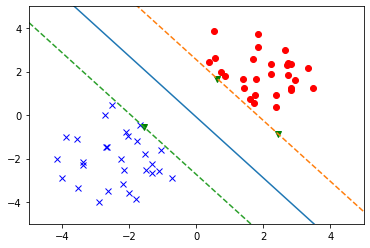

In [40]:
# 決定境界のy座標はこちら
def classifier(w1, w2, b, x):
    return -w1/w2*x - b/w2

# marginの座標を計算、 m=1,-1
def margin(w1, w2, b, x,m):
    return -w1/w2*x - b/w2 +m/w2


for xi, yi in zip(x, y):
    # サポートベクトルの描画
    # 条件としてはモレがあるが、ほぼモレは起こりえないのでこのまま。
    if (xi[0] in x_m and xi[1] in x_m) or \
            (xi[0] in x_p and xi[1] in x_p):
        plt.plot(xi[0], xi[1], 'gv')
        continue
    # ラベルごとに記号を分ける
    if yi == 1:
        plt.plot(xi[0], xi[1], 'ro')
    else:
        plt.plot(xi[0], xi[1], 'bx')
x2 = np.linspace(-5, 5, 100)
y2 = classifier(w[0], w[1], b, x2)
plt.plot(x2, y2)
plt.plot(x2, margin(w[0], w[1], b, x2,1),linestyle = "dashed")
plt.plot(x2, margin(w[0], w[1], b, x2,-1),linestyle = "dashed")
plt.xlim([-5, 5])
plt.ylim([-5, 5])